# EEG Data Processing

### About the dataset

The EEG data used is a database collected and made available by the Child Mind Institute. 

It is part of the Multimodal Resource for Studying Information Processing in the Developing Brain (MIPDB) database.

MIPDB Link: http://fcon_1000.projects.nitrc.org/indi/cmi_eeg/

EEG Data Link: http://fcon_1000.projects.nitrc.org/indi/cmi_eeg/eeg.html

In [34]:
%matplotlib inline

import os
import csv
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

# Import custom project related code
from utils import comb_corrs, bet_corrs

# Custom imports
from slf.core.db import SLFDB
from slf.core.io import save_pickle, load_pickle

# Import FOOOF
from fooof import FOOOF, FOOOFGroup

### Checking 

In [2]:
# Initialize project database object
db = SLFDB()
subjs = db.check_subjs()

In [3]:
# Load data readme file
rmd_file = os.path.join(db.data_path, 'EEG', 'MIPDB_PublicFile.csv')
df = pd.read_csv(rmd_file)

In [4]:
# Check which subjects are downloaded
all_subjs = set(df.ID)

# Subjects with no data (info from README)
no_dat = ['A00052593', 'A00054122', 'A00055801', 'A00056158', 'A00056640', 'A00056990']

# Check if any subjects still need downloading
to_dl = all_subjs - set(subjs) - set(no_dat)

# Print out results
print('Number of subjects downloaded: ', len(set(subjs)))
print('Number of subjects left to download: ', len(to_dl))

Number of subjects downloaded:  120
Number of subjects left to download:  0


### Subjects

In [5]:
# Set subject to run
cur_subj = subjs[90]

# Get subject data files
dat_f, ev_f, _ = db.get_subj_files(cur_subj)

In [6]:
# Get the resting data file - file 001
temp = [ef.split('_')[1] for ef in ev_f]
temp = [fn[-3:] for fn in temp]
f_ind = None
for i, tt in enumerate(temp):
    if tt == '001':
        f_ind = i
if f_ind is None:
    print('No file found')

In [7]:
# Get file file path for data file & associated event file
dat_f_name = db.gen_dat_path(cur_subj, dat_f[f_ind])
eve_f_name = db.gen_dat_path(cur_subj, ev_f[f_ind])

In [8]:
# Data info / parameters
s_freq = 500

# Load data file
dat = np.loadtxt(dat_f_name, delimiter=',')

In [9]:
# Read in list of channel names that are kept in reduced 111 montage
with open('../data/chans111.csv', 'r') as csv_file:
    reader = csv.reader(csv_file)
    ch_labels = list(reader)[0]
    
# Read montage, reduced to 111 channel selection
montage = mne.channels.read_montage('GSN-HydroCel-129', ch_names=ch_labels)

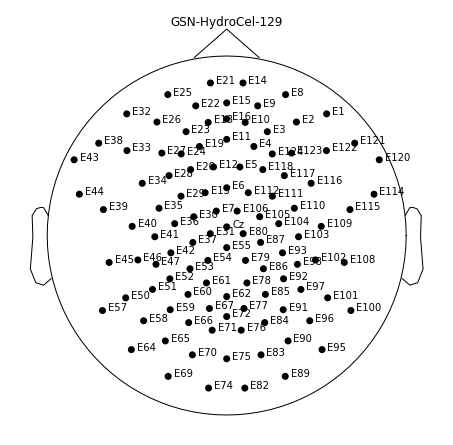

In [10]:
# Check out the montage plot
montage.plot();

In [11]:
# Create the info structure needed by MNE
info = mne.create_info(ch_labels, s_freq, 'eeg', montage)

# Create the MNE Raw data object
raw = mne.io.RawArray(dat, info)

Creating RawArray with float64 data, n_channels=111, n_times=174329
    Range : 0 ... 174328 =      0.000 ...   348.656 secs
Ready.


In [12]:
# Create a stim channel
stim_info = mne.create_info(['stim'], s_freq, 'stim')
stim_raw = mne.io.RawArray(np.zeros(shape=[1, len(raw._times)]), stim_info)

# Add stim channel to data object
raw.add_channels([stim_raw], force_update_info=True)

Creating RawArray with float64 data, n_channels=1, n_times=174329
    Range : 0 ... 174328 =      0.000 ...   348.656 secs
Ready.


<RawArray  |  None, n_channels x n_times : 112 x 174329 (348.7 sec), ~149.3 MB, data loaded>

In [13]:
# Load events from file

# Initialize headers and variable to store event info
headers = ['type', 'value', 'latency', 'duration', 'urevent']
evs = np.empty(shape=[0, 3])

# Load events from csv file
with open(eve_f_name, 'r') as csv_file:
    
    reader = csv.reader(csv_file)
    for row in reader:

        # Skip the empty rows
        if row == []: continue
        
        # Skip the header row, since there is one for every event...
        if row[0] == 'type': continue
        
        # Collect actual event data rows
        evs = np.vstack((evs, np.array([int(row[2]), 0, int(row[0])])))

# Add events to data object
raw.add_events(evs, stim_channel='stim')

# Check events
dat_evs = mne.find_events(raw)

12 events found
Events id: [20 30 90]


In [14]:
# Find flat channels and set them as bad
flat_chans = np.mean(raw._data[:111, :], axis=1) == 0
raw.info['bads'] = list(np.array(raw.ch_names[:111])[flat_chans])
print('Bad channels: ', raw.info['bads'])

Bad channels:  ['E8', 'E14', 'E21', 'E25', 'E32']


In [15]:
# Interpolate bad channels
raw.interpolate_bads()

Computing interpolation matrix from 106 sensor positions
Interpolating 5 sensors


/Users/tom/anaconda/envs/eeg36/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


<RawArray  |  None, n_channels x n_times : 112 x 174329 (348.7 sec), ~149.3 MB, data loaded>

In [16]:
# Set average reference
raw.set_eeg_reference()
raw.apply_proj()

The behavior of set_eeg_reference will change in 0.16 when ref_channels="average". Currently, a projection is computed, which has to be applied manually with the apply_proj method. In 0.16, the average reference will be directly applied. Set projection=True if you want to retain the old behavior, or set projection=False if you want the new behavior.
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated


<ipython-input-16-20a53777281e>:2: DeprecationWarning: The behavior of set_eeg_reference will change in 0.16 when ref_channels="average". Currently, a projection is computed, which has to be applied manually with the apply_proj method. In 0.16, the average reference will be directly applied. Set projection=True if you want to retain the old behavior, or set projection=False if you want the new behavior.
  raw.set_eeg_reference()


SSP projectors applied...


<RawArray  |  None, n_channels x n_times : 112 x 174329 (348.7 sec), ~149.3 MB, data loaded>

## Resting EEG event descriptions

- 90: Start of the resting EEG paradigm
- 20: Eyes open start (20 seconds)
- 30: Eyes closed start (40 seconds)

^ There should be 5 of each EO and EC

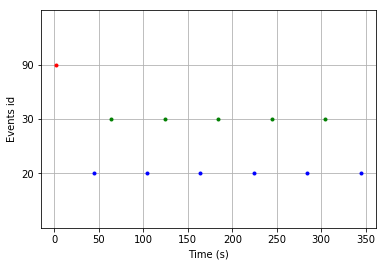

In [17]:
_ = mne.viz.plot_events(dat_evs, raw.info['sfreq'])

In [18]:
# Get good eeg channel indices
eeg_chans = mne.pick_types(raw.info, meg=False, eeg=True)

# Epoch resting eeg data events
eo_epochs = mne.Epochs(raw, events=dat_evs, event_id={'EO': 20}, tmin=2, tmax=18,
                       baseline=None, picks=eeg_chans, preload=True)
ec_epochs = mne.Epochs(raw, events=dat_evs, event_id={'EC': 30}, tmin=2, tmax= 38,
                       baseline=None, picks=eeg_chans, preload=True)

6 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 6 events and 8001 original time points ...
1 bad epochs dropped
5 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 18001 original time points ...
0 bad epochs dropped


In [19]:
# Plot topo-plots of oscillatory activity
#eo_epochs.plot_psd_topomap();
#ec_epochs.plot_psd_topomap();

In [20]:
# Calculate PSDs - EO Data
eo_psds, eo_freqs = mne.time_frequency.psd_welch(eo_epochs, fmin=2., fmax=40., n_fft=1000,
                                                 n_overlap=250, verbose=False)

# Average PSDs for each channel across each rest block
eo_avg_psds = np.mean(eo_psds, axis=0)

In [21]:
# Calculate PSDs - EC Data
ec_psds, ec_freqs = mne.time_frequency.psd_welch(ec_epochs, fmin=3., fmax=40., n_fft=1000,
                                                 n_overlap=250, verbose=False)

# Average PSDs for each channel across each rest block
ec_avg_psds = np.mean(ec_psds, axis=0)

In [22]:
# Save out PSDs
#np.savez(str(cur_subj) + 'ec_psds.npz', ec_freqs, ec_avg_psds, np.array(ec_epochs.ch_names))
#np.savez(str(cur_subj) + 'eo_psds.npz', eo_freqs, eo_avg_psds, np.array(eo_epochs.ch_names))

### Fit FOOOF (Check)

In [23]:
# Settings
f_range = [3, 35]

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 35 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                          0.4468, 1.5440                                          
                                                                                                  
                                       4 peaks were found:                                        
          

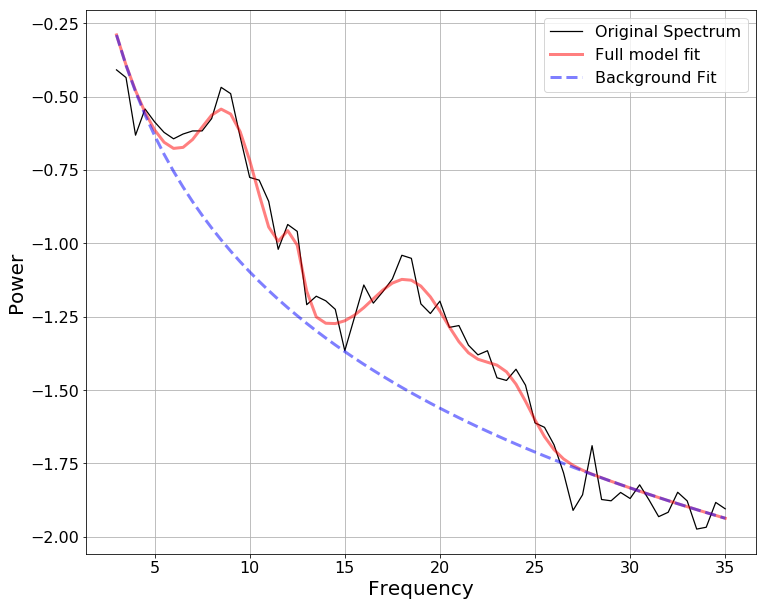

In [24]:
# Fit FOOOF, to example PSD
fm = FOOOF(peak_width_limits=[1, 8], max_n_peaks=6, min_peak_amplitude=0.2)
fm.report(eo_freqs, eo_avg_psds[65, :], f_range)

In [25]:
# Fit FOOOF to PSDs averaged across rest epochs
fg = FOOOFGroup(peak_width_limits=[1, 8], max_n_peaks=6)
fg.fit(eo_freqs, eo_avg_psds, f_range)
sls_eo_avg = fg.get_all_data('background_params', 'slope')
fg.fit(ec_freqs, ec_avg_psds, f_range)
sls_ec_avg = fg.get_all_data('background_params', 'slope')

In [26]:
# Fit FOOOF to PSDs from each epoch
eo_fgs = []
for ep_psds in eo_psds:
    fg.fit(eo_freqs, ep_psds, f_range)
    eo_fgs.append(fg.copy())
sls_eo = [fg.get_all_data('background_params', 'slope') for fg in eo_fgs]
    
ec_fgs = []
for ep_psds in ec_psds:
    fg.fit(ec_freqs, ep_psds, f_range)
    ec_fgs.append(fg.copy())
sls_ec = [fg.get_all_data('background_params', 'slope') for fg in ec_fgs]

In [27]:
# Get the average slope values 
eo_avgs = [np.mean(sls) for sls in sls_eo]
ec_avgs = [np.mean(sls) for sls in sls_ec]

# Check out the average values
print(np.mean(eo_avgs))
print(np.mean(ec_avgs))

1.396851225020167
1.3662954403454706


In [28]:
# Check range of slopes
print(min(sls_eo_avg))
print(max(sls_eo_avg))

print(min(sls_ec_avg))
print(max(sls_ec_avg))

1.1458692842328562
1.8505601883759355
1.066677121819809
2.179170656644794


In [29]:
# Collect data together
subj_dat = {
    'ID' : cur_subj,
    'sls_eo_avg' : sls_eo_avg,
    'sls_ec_avg' : sls_ec_avg,
    'sls_eo' : sls_eo,
    'sls_ec' : sls_ec
}

In [30]:
# Save out data
f_name = 'test_subj.p'
save_pickle(subj_dat, f_name, db.fooof_path)

In [31]:
# Check for saved FOOOF files
fres_files = db.check_fooof()
f_ind = fres_files.index(f_name)

In [32]:
# Load pickle file of FOOOF results
dat = load_pickle(fres_files[f_ind], db.fooof_path)

### Epoch Correlations

In [35]:
# Check correlations between epochs
corrs_eo = comb_corrs(sls_eo)
print('Corrs within EO: \t', np.mean(corrs_eo))
    
corrs_ec = comb_corrs(sls_ec)
print('Corrs within EC: \t', np.mean(corrs_ec))

corrs_bet = bet_corrs(sls_eo, sls_ec)
print('Corrs betwee EC/EO: \t', np.mean(corrs_bet))

Corrs within EO: 	 0.3117525137638265
Corrs within EC: 	 0.5830424093397132
Corrs betwee EC/EO: 	 0.4571820360374022


### Topography Plots

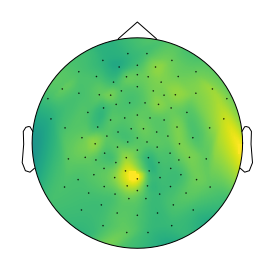

In [36]:
# Plot slope topography from average eyes-open data
mne.viz.plot_topomap(sls_eo_avg, raw.info, cmap=cm.viridis, contours=0);

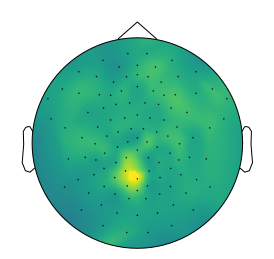

In [37]:
# Plot slope topography from average eyes-closed data
mne.viz.plot_topomap(sls_ec_avg, raw.info, cmap=cm.viridis, contours=0);

In [38]:
# Calculate difference plot between EC and EO
diff_sl = [sec - seo for sec, seo in zip(sls_ec_avg, sls_eo_avg)]

print(min(diff_sl))
print(max(diff_sl))

-0.29036913854609114
0.32861046826885865


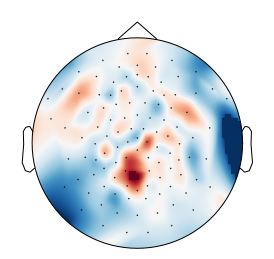

In [39]:
# Plot difference map between EC and EO
mne.viz.plot_topomap(diff_sl, raw.info, contours=0);